# import libraries

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Load the data 

In [150]:
target=pd.read_csv('training_set_labels.csv').sort_values(by='id')
features=pd.read_csv('Training_set_values.csv').sort_values(by='id')


In [151]:
df=target.merge(features,on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0,non functional,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
1,1,functional,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,none,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,2,functional,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,...,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
3,3,functional,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
4,4,non functional,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump


In [153]:
df.ward.value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Izia           1
Igogo          1
Mkumbi         1
Kinungu        1
Nsemulwa       1
Name: ward, Length: 2092, dtype: int64

# Data Cleaning

In [4]:
# check missing values
missing=pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns=['feature','missing_values']
missing

,feature,missing_values
0,id,0
1,status_group,0
2,amount_tsh,0
3,date_recorded,0
4,funder,3635
5,gps_height,0
6,installer,3655
7,longitude,0
8,latitude,0
9,wpt_name,0


In [129]:
# delete the columns which contains more than 20% missing values
col_names=[]
for i in range(len(missing)):
    if missing['missing_values'][i]/len(df)<=0.2:
        col_names.append(missing['feature'][i])
print(col_names)

['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [132]:
# remove all missing data 
df0=df[col_names].dropna(axis=0)
df0.shape

(48288, 40)

# Data Engineering

## Target

In [158]:
# give value for status group and create a new column called target 
df0['target']=df0['status_group'].map({'functional':1,
                                        'functional needs repair':2,
                                        'non functional':0})
df0['target'].value_counts()

1    26517
0    18273
2     3498
Name: target, dtype: int64

## Features

### Create a function to transform non-numerical labels

In [159]:
from sklearn import  preprocessing

In [160]:
def encode(data):
    le = preprocessing.LabelEncoder()
    le.fit(data)
    return le.transform(data)

In [161]:

df0['date_recorded']=df0['date_recorded'].apply(lambda x : x[:4] )

### data transform

In [162]:
df1=df0.copy()

In [163]:
for i in df1.columns:
    df1[i]=encode(df1[i])

In [164]:
df1.info

<bound method DataFrame.info of           id  status_group  amount_tsh  date_recorded  funder  gps_height  \
2          0             0           0              2     708          59   
3          1             0           8              4     372        1697   
4          2             2           0              2     170          59   
5          3             0          17              2    1052          87   
6          4             2           0              3     387          59   
...      ...           ...         ...            ...     ...         ...   
59395  48283             0           0              4    1560        1241   
59396  48284             0           0              2     212          59   
59397  48285             2           0              3     806        1246   
59398  48286             2          17              2    1169        1486   
59399  48287             2          17              4     813        1023   

       installer  longitude  latitude  wpt_

In [165]:
df0[['id','longitude' , 'latitude']].merge(df1[['id','longitude' , 'latitude']],on='id')

,id,longitude_x,latitude_x,longitude_y,latitude_y
0,2,36.115056,-6.279268,28221,20559
1,3,37.147432,-3.187555,45418,16281
2,4,36.164893,-6.099289,11901,31535
3,5,39.286124,-6.972403,28528,17703
4,6,33.229880,-3.852983,27384,20909
...,...,...,...,...,...
31417,48281,31.159952,-6.374470,40708,22141
31418,48282,33.870623,-4.285867,15873,9484
31419,48283,33.095071,-9.224173,32419,37664
31420,48284,37.674448,-3.620035,14724,9668


In [166]:
df2=df1.drop(columns=['id','status_group']) # frop ID and status_group

In [167]:
df2.columns# double check the columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'target'],
      dtype='object')

In [168]:
# 5 first 

# Declare inputs and target

In [291]:
drop_list=['target','num_private','wpt_name','quantity_group','recorded_by','construction_year','management_group','subvillage']

In [292]:
inputs=df2.drop(columns=drop_list)
inputs.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
2,0,2,708,59,781,28012,19758,8,2,0,...,4,5,6,2,2,3,0,0,2,1
3,8,4,372,1697,163,33459,39657,5,6,2,...,4,5,6,2,1,8,6,0,1,1
4,0,2,170,59,188,28221,20559,8,2,0,...,6,6,6,2,0,7,5,0,4,3
5,17,2,1052,87,1162,45418,16281,8,14,23,...,4,5,6,2,1,3,0,0,2,1
6,0,3,387,59,476,11901,31535,0,17,16,...,0,2,6,2,3,7,5,0,6,5


In [293]:
inputs.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [294]:
target=df2.target

# Train test split

In [295]:
x_train, x_test, y_train, y_test = train_test_split(inputs,target, random_state=46,test_size=0.2)

In [296]:
x_train=pd.DataFrame(data=x_train, columns=x_train.columns)
x_test=pd.DataFrame(data=x_test, columns=x_train.columns)

# Feature Selection

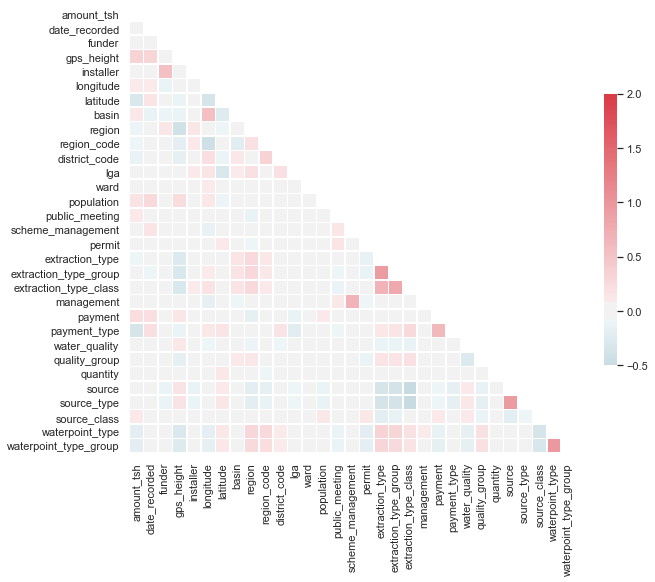

In [297]:

sns.set(style="white")


# Compute the correlation matrix
corr = x_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})
plt.show()

In [298]:
# Create correlation matrix
corr_matrix = x_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
x_train.drop(columns=to_drop, inplace=True)
x_test.drop(columns=to_drop, inplace=True)
feature_columns=x_train.columns

In [299]:
x_train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_type', 'source_class', 'waterpoint_type'],
      dtype='object')

In [300]:
inputs.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [301]:
for i in inputs.columns:
    if i not in x_train.columns:
        print(i)

waterpoint_type_group


In [302]:
#  waterpoint_type_group got removed

# oversampling

In [303]:
from sklearn.utils import resample
# concatenate our training data back together
training  = pd.DataFrame()
training[list(x_train.columns)]=x_train
training['target']=y_train
training.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,target
59246,0,3,437,1317,322,15183,44882,4,9,19,...,6,6,4,4,2,7,5,0,6,0
9551,30,2,615,1623,1606,21167,10647,6,3,10,...,5,3,6,2,1,1,0,0,4,1
10013,0,3,289,59,322,0,46917,4,17,16,...,0,2,6,2,1,7,5,0,4,1
3732,0,4,387,1233,345,3971,19901,2,15,14,...,0,2,6,2,1,3,0,0,4,1
57275,0,2,607,59,322,27211,27059,0,2,0,...,4,5,6,2,1,3,0,0,2,2


In [304]:
# separate minority and majority classes
not_func= training[training.target==0]
func= training[training.target==1]
func_rep= training[training.target==2]

In [305]:
# Get a class count to understand the class imbalance.
print('not funtional count: '+ str(len(not_func)))
print('funtional count: '+ str(len(func)))
print('func_rep count: '+ str(len(func_rep)))

not funtional count: 14675
funtional count: 21181
func_rep count: 2774


In [306]:
# upsample minority
not_func_upsampled = resample(not_func,
                          replace=True, # sample with replacement
                          n_samples=len(func), # match number in majority class
                          random_state=23) # reproducible results
not_func_upsampled.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,target
28142,0,4,212,935,279,27751,2510,7,16,9,...,5,3,6,2,2,7,5,0,6,0
47065,0,2,1528,59,891,27145,20162,8,2,0,...,4,5,4,4,0,3,0,0,1,0
29825,0,3,437,1452,322,16577,45002,4,9,19,...,5,3,6,2,1,7,5,0,6,0
46769,0,4,355,359,415,44275,1168,7,12,25,...,6,6,6,2,0,7,5,0,6,0
54469,0,2,387,59,322,9642,42968,4,13,18,...,0,2,6,2,1,7,5,0,4,0


In [307]:
# upsample minority
func_rep_count_upsampled = resample(func_rep,
                          replace=True, # sample with replacement
                          n_samples=len(func), # match number in majority class
                          random_state=23) # reproducible results
func_rep_count_upsampled.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,region_code,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,target
3374,34,4,501,1035,322,335,25490,3,5,15,...,3,1,6,2,1,6,4,1,2,2
10390,0,3,467,59,554,18188,32403,0,17,16,...,0,2,6,2,3,5,3,1,1,2
28578,30,2,357,1383,462,31071,19971,8,11,4,...,3,1,6,2,1,8,6,0,1,2
21268,25,4,1558,1400,1706,1068,29188,3,5,15,...,3,1,6,2,1,6,4,1,1,2
35067,0,2,1528,59,322,25855,27311,0,2,0,...,4,5,6,2,1,3,0,0,1,2


In [308]:
# combine those datasets
upsampled= pd.concat([func, not_func_upsampled,func_rep_count_upsampled])
upsampled.target.value_counts()

2    21181
1    21181
0    21181
Name: target, dtype: int64

In [309]:
# declare x_train and y_train
y_train = upsampled.target
x_train = upsampled.drop('target', axis=1)

# data standardization 

In [310]:
#import library for data standardization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  
scaler.fit(x_train)

X_train = scaler.transform(x_train)  
X_test = scaler.transform(x_test)  

## gridsearch

In [64]:
from sklearn.model_selection import RandomizedSearchCV

In [65]:
# given prameters different values
random_grid={
             'n_estimators':list(range(300,400,10)),
             'max_depth':list(range(1,30,2)),
             'max_features':list(range(1,19)),
             'min_samples_leaf':list(range(1,19)),
             'min_samples_split':list(range(1,19))                   
                            
                                
            }

In [66]:
# random forest model
rfc=RandomForestClassifier(
                             n_jobs=-1,
                             random_state=42,
                             
    
)

In [67]:
# randommized searchCV
RS=RandomizedSearchCV(rfc,random_grid,cv=10)


In [1]:
# fit the train data
RS.fit(X_train,y_train)

In [69]:
# obtian best parameters
RS.best_params_

{'n_estimators': 350,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 21}

In [70]:
# best score
RS.best_score_

0.8872416639363323

# Random Forest model with best parameters

In [311]:
rfc=RandomForestClassifier(
    n_estimators= 350,
 min_samples_split= 9,
 min_samples_leaf= 2,
 max_features= 8,
 max_depth= 21,
 n_jobs=-1,
 random_state=42)


In [312]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=21, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [313]:
y_train_pre=rfc.predict(X_train)

In [314]:
print('Accuracy score of train data :{}'.format(rfc.score(X_train,y_train)))
print('Accuracy score of test data:{}'.format(rfc.score(X_test,y_test)))


Accuracy score of train data :0.9466660371716791
Accuracy score of test data:0.7840132532615448


In [315]:
# obtian train data f1_Score
pre_train=rfc.predict(X_train)
print('Train data f1_Score:{}'.format(f1_score(y_train, pre_train,average='weighted')))
# Obtain Test data f1_Score
y_pred=rfc.predict(X_test)
print('Test data f1_Score:{}'.format(f1_score(y_test, y_pred,average='weighted')))

Train data f1_Score:0.9463544709975049
Test data f1_Score:0.7918363993820672


# Confusion Matrix

In [109]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [110]:
confusion=metrics.confusion_matrix(y_test, y_pred)
print(confusion)

[[2751  652  195]
 [ 427 4382  527]
 [  65  222  437]]


In [111]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
classes = ['Functional', 'Not Functional','Functional but need to repair']

In [112]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[2751  652  195]
 [ 427 4382  527]
 [  65  222  437]]


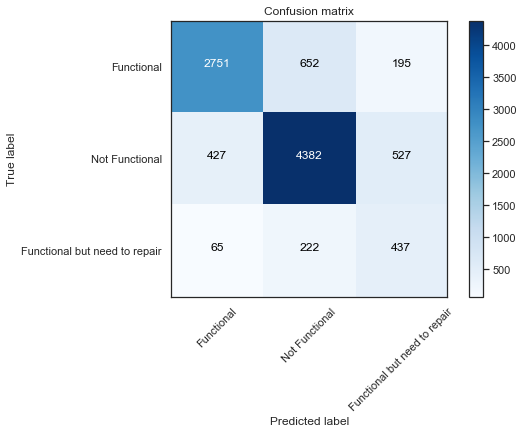

In [113]:
import itertools
plt.figure(figsize=(8,6))
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [114]:
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [115]:
precision=metrics.precision_score(y_test, y_pred,average='weighted')
recall=metrics.recall_score(y_test, y_pred,average='weighted')
precision,recall

(0.8049102480129322, 0.7838061710499068)

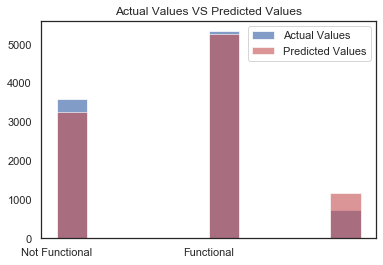

In [116]:
plt.hist(y_test,alpha=0.7,color='b',label='Actual Values')
plt.hist(smote_pred,alpha=0.6,color='r',label='Predicted Values')
plt.title('Actual Values VS Predicted Values')
plt.xticks([0, 1],['Not Functional', 'Functional'])
plt.legend()
plt.show()

# Feature Importance

In [118]:
importances = rfc.feature_importances_

feature_importance=pd.DataFrame()
feature_importance['feature']=x_train.columns
feature_importance['weight']=importances 
table=feature_importance.sort_values(by='weight',ascending=False)
table

,feature,weight
5,longitude,0.139096
26,quantity,0.113656
6,latitude,0.108853
3,gps_height,0.066438
12,ward,0.051194
2,funder,0.044524
13,population,0.043547
11,lga,0.039097
4,installer,0.036649
30,waterpoint_type,0.035367


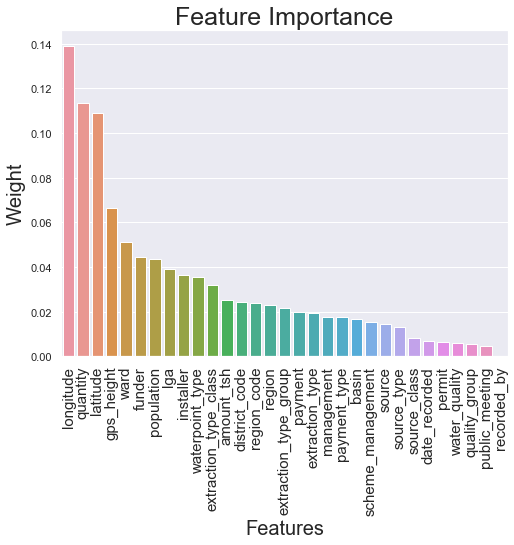

In [265]:
plt.figure(figsize=(8,6))
sns.barplot(table['feature'],table['weight'])
plt.xticks(np.arange(len(x_train.columns)),rotation=90,size=15)
plt.title('Feature Importance',fontsize=25)
plt.xlabel('Features',fontsize=20)
plt.ylabel('Weight',fontsize=20)
plt.show()